# RHme3: It's a Kind of Magic

You managed to get a spare key fob for the car you like. However you want to duplicate it so that you can maintain your access to it. Through extensive reverse engineering, you figure out that the device accepts an input challenge performs AES-128 encryption (or decryption) and returns the response. It is also identified that the device operates on masked input and returns masked output. Extract the key so you can get free rides!

The device expects 18 bytes of input: the first byte should be either 0xAE (for encryption) or 0xAD (for decryption) followed by 16 bytes of data, followed by a newline.

In [1]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

## Explore the traces

Before we can mount any kind of attack, we need to understand what's happening. To do that, we need to visualize the data, and check out what we can see.

In [2]:
# load the traceset
trs = InspectorTrace("IKM-500 + Resampled (sync) + StaticAlign + Trim.trs")

[x] Skipping unknown tag 70 with length 5
[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
[x] Skipping unknown tag 104 with length 4
[x] Skipping unknown tag 105 with length 1
[x] Skipping unknown tag 106 with length 1
Opened IKM-500 + Resampled (sync) + StaticAlign + Trim.trs, #traces 500, #samples 33050 (Float32), #data 32, #title 45


Jlsca.Trs.InspectorTrace(0x2d, Nullable{Int64}(500), 0x0020, 4, Float32, 0x0000811a, 61, IOStream(<file IKM-500 + Resampled (sync) + StaticAlign + Trim.trs>), Any[], Any[], Union, Union, 0, "IKM-500 + Resampled (sync) + StaticAlign + Trim.trs", 61, false, 2, false, Nullable{Range}())

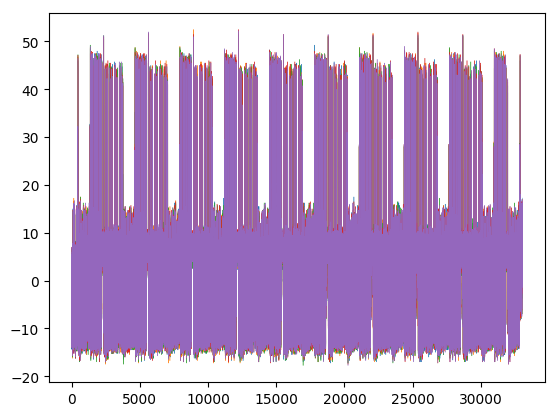

In [3]:
# read and plot 10 traces with some zoom
((data,samples),eof) = readTraces(trs, 1:5);
plot(samples[1:end,1:end]', linewidth=.3); # note the transpose; and here you can play with the zoom
; # suppress output

Above we can clearly see the AES structure. Just by counting the sections, we can get a good idea of what is what.
* There are 11 AddRoundKeys, and those are the first and last operations
* There are 10 each SubBytes and ShiftRows
* There are 9 MixColumns

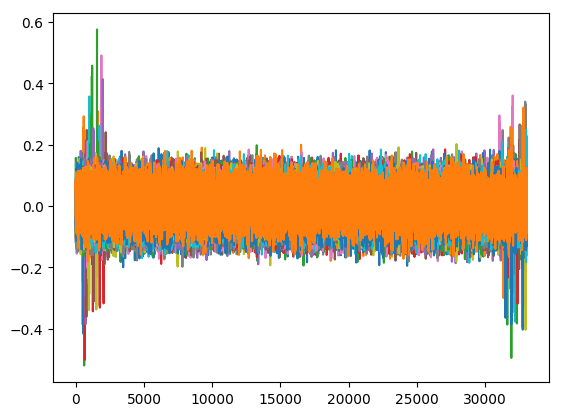

In [4]:
# Plot data correlations
((data,samples),eof) = readTraces(trs, 1:500)
plot(cor(samples[1:end,1:end], data[:,1:32]))
;

In [5]:
# Plot up to the end of the first round, and the input data correlations
firstRound = 400:4600
((data,samples),eof) = readTraces(trs, 1:10);
plot(samples[1:10,firstRound]', linewidth=.3);
figure()
((data,samples),eof) = readTraces(trs, 1:nrTraces);
plot(cor(samples[1:end,firstRound], data[:,1:16]))
;

LoadError: [91mUndefVarError: nrTraces not defined[39m

The four visible sections are the initial AddRoundKey, then SubBytes, ShiftRows, MixColumns, and AddRoundKey. The input data correlations are clustered in the initial AddRoundKey step, with significant correlations still visible in SubBytes. While correlations often persist through an XOR, SubBytes, doing what it does, breaks all input correlations.

## Run correlation power analysis

This is the actual run section. Even though it's using AES-128, we are going to launch a AES-256 attack.

In [6]:
params = DpaAttack(AesSboxAttack(), CPA())
params.attack.mode = CIPHER       # attack encrypt
params.attack.keyLength = KL256
params.dataOffset = 1             # the input data is at the beginning
params.attack.direction = FORWARD # attack the start of encrypt, not the end

params.analysis.leakages = [HW()]
params.maximization = AbsoluteGlobalMaximization()

range = 1300:5600 # we need to include the first two rounds
addSamplePass(trs, x -> x[range])
sca(trs, params, 1, length(trs))
popSamplePass(trs)


Jlsca running in Julia version: 0.6.2, 1 processes/1 workers/1 threads per worker

DPA parameters
attack:       AES Sbox
mode:         CIPHER
key length:   KL256
direction:    FORWARD
xor:          false
analysis:     CPA
leakages:     HW
maximization: abs global max
data at:      1

phase: 1 / 2, #targets 16

Attacking columns 1:4301 out of 4301 columns
CPA on samples shape (500, 4301) (range 1:4301) and data shape (500,)
Results @ 500 rows, 4301 cols (1015 rows, 4301 cols, consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0xfb, peak: 0.783756 @ 1090
rank:   2, candidate: 0x70, peak: 0.264503 @ 3566
rank:   3, candidate: 0x2f, peak: 0.237630 @ 112
rank:   4, candidate: 0xae, peak: 0.236492 @ 1096
rank:   5, candidate: 0x7c, peak: 0.232591 @ 133
recovered key material: fb
CPA on samples shape (500, 4301) (range 1:4301) and data shape (500,)
Results @ 500 rows, 4301 cols (1015 rows, 4301 cols, consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
ran

Results @ 500 rows, 4301 cols (500 rows, 4301 cols, consumed)
target: 2, phase: 2, #candidates 256, "Sbox out"
rank:   1, candidate: 0x8a, peak: 0.549574 @ 3618
rank:   2, candidate: 0xea, peak: 0.256240 @ 3613
rank:   3, candidate: 0xfe, peak: 0.245311 @ 3613
rank:   4, candidate: 0x21, peak: 0.228436 @ 3631
rank:   5, candidate: 0xe0, peak: 0.226822 @ 468
recovered key material: 8a
CPA on samples shape (500, 4301) (range 1:4301) and data shape (500,)
Results @ 500 rows, 4301 cols (500 rows, 4301 cols, consumed)
target: 3, phase: 2, #candidates 256, "Sbox out"
rank:   1, candidate: 0xe1, peak: 0.547180 @ 4283
rank:   2, candidate: 0x8d, peak: 0.261055 @ 3821
rank:   3, candidate: 0xc9, peak: 0.242233 @ 4269
rank:   4, candidate: 0xb6, peak: 0.230010 @ 2618
rank:   5, candidate: 0x4b, peak: 0.213551 @ 984
recovered key material: e1
CPA on samples shape (500, 4301) (range 1:4301) and data shape (500,)
Results @ 500 rows, 4301 cols (500 rows, 4301 cols, consumed)
target: 4, phase: 2, #ca

Looking at the correlations, they're pretty solid, but we don't have the flag yet. What we have is the masked first round key, and the actual second round key. The reason this works, is because the second round key is derived using the expected input to the second round SBox, which Jlsca now can accurately compute.

We on the other hand, want the key, which we can derive from the second round key by reversing the key schedule:

In [7]:
phaseInput = get(params.phaseInput)
maskedRoundKey1 = phaseInput[1:16]
roundKey2 = phaseInput[17:32]
roundKeyLength = div(length(roundKey2),Aes.wz)
keySchedule = KeyExpansionBackwards(roundKey2, Aes.keylength2Nr(length(roundKey2)), roundKeyLength, roundKeyLength)
finalKey = keySchedule[1:16]
print("Recovered key: ", bytes2hex(finalKey),"\n")
if finalKey == hex2bytes("2c66704041a085fb735fc7013f5783ac")
    print("Which is the correct flag.")
else
    print("but something messed up!")
end

Recovered key: 2c66704041a085fb735fc7013f5783ac
Which is the correct flag.

# Can we prove it?
Yes. Just for fun, we'll prove it's the right key, by checking from the other side, deriving the masks, and doing an encryption. To do that, we need to recover the input and output masks. We can recover the input mask already, but we need to repeat the SCA above on the last two rounds to get the output mask:

In [8]:
backParams = DpaAttack(AesSboxAttack(), CPA())
backParams.attack.mode = CIPHER        # attack encrypt
backParams.attack.keyLength = KL256
backParams.dataOffset = 17             # the output data is at the end
backParams.attack.direction = BACKWARD # attack the end of encrypt

backParams.analysis.leakages = [HW()]
backParams.maximization = AbsoluteGlobalMaximization()

range = 27500:32000 # we need to include the last two rounds
addSamplePass(trs, x -> x[range])
sca(trs, backParams, 1, length(trs))
popSamplePass(trs)


Jlsca running in Julia version: 0.6.2, 1 processes/1 workers/1 threads per worker

DPA parameters
attack:       AES Sbox
mode:         CIPHER
key length:   KL256
direction:    BACKWARD
xor:          false
analysis:     CPA
leakages:     HW
maximization: abs global max
data at:      17

phase: 1 / 2, #targets 16

Attacking columns 1:4501 out of 4501 columns
CPA on samples shape (500, 4501) (range 1:4501) and data shape (500,)
Results @ 500 rows, 4501 cols (500 rows, 4501 cols, consumed)
target: 1, phase: 1, #candidates 256, "Inverse sbox out"
rank:   1, candidate: 0x13, peak: 0.648035 @ 3520
rank:   2, candidate: 0xc2, peak: 0.213914 @ 3521
rank:   3, candidate: 0xc4, peak: 0.212886 @ 1669
rank:   4, candidate: 0x9a, peak: 0.209826 @ 2294
rank:   5, candidate: 0xd1, peak: 0.209307 @ 3520
recovered key material: 13
CPA on samples shape (500, 4501) (range 1:4501) and data shape (500,)
Results @ 500 rows, 4501 cols (500 rows, 4501 cols, consumed)
target: 2, phase: 1, #candidates 256, "Inv

Results @ 500 rows, 4501 cols (500 rows, 4501 cols, consumed)
target: 2, phase: 2, #candidates 256, "Inverse sbox out"
rank:   1, candidate: 0xfa, peak: 0.375456 @ 480
rank:   2, candidate: 0x5a, peak: 0.246035 @ 1386
rank:   3, candidate: 0x63, peak: 0.215348 @ 1379
rank:   4, candidate: 0x06, peak: 0.209752 @ 2157
rank:   5, candidate: 0x20, peak: 0.209066 @ 3573
recovered key material: fa
CPA on samples shape (500, 4501) (range 1:4501) and data shape (500,)
Results @ 500 rows, 4501 cols (500 rows, 4501 cols, consumed)
target: 3, phase: 2, #candidates 256, "Inverse sbox out"
rank:   1, candidate: 0x5d, peak: 0.543924 @ 750
rank:   2, candidate: 0xbe, peak: 0.226511 @ 1407
rank:   3, candidate: 0xb0, peak: 0.220112 @ 772
rank:   4, candidate: 0x1f, peak: 0.218677 @ 1343
rank:   5, candidate: 0xc1, peak: 0.216119 @ 1453
recovered key material: 5d
CPA on samples shape (500, 4501) (range 1:4501) and data shape (500,)
Results @ 500 rows, 4501 cols (500 rows, 4501 cols, consumed)
target: 4

In [9]:
backPhaseInput = get(backParams.phaseInput)
maskedRoundKey11 = backPhaseInput[1:16]
roundKey10 = reshape(Aes.MixColumns(reshape(backPhaseInput[17:32], (4,4))), 16)
roundKeyLength = div(length(roundKey10),Aes.wz)
backKeySchedule = KeyExpansionBackwards(roundKey10, Aes.keylength2Nr(length(roundKey10)), roundKeyLength, roundKeyLength*9)

backKey = keySchedule[1:16]
print("Recovered key: ", bytes2hex(backKey),"\n")
if backKey == finalKey
    print("Which matches the forward direction.")
else
    print("but something messed up!")
end

Recovered key: 2c66704041a085fb735fc7013f5783ac
Which matches the forward direction.

Note the bit of hackery above. The "recovered key material" isn't the 10th round key, it's the InvMixColumns of the 10th round key. This is because the code is designed to be able to keep going to the 9th, 8th, etc, so it has to deal in complete rounds, but the last round is an abbreviated round. We fix that by applying MixColumns to it.

And now, to derive the output masks:

In [10]:
# Check the key to see if it decrypts the data
keySchedule = KeyExpansion(finalKey, Aes.keylength2Nr(length(roundKey2)), roundKeyLength)
inputMask = xor.(maskedRoundKey1, keySchedule[1:16])
outputMask = xor.(maskedRoundKey11, keySchedule[161:176])
plaintext = trs[1][1][1:16]
ciphertext = trs[1][1][17:32]

w = KeyExpansion(finalKey, 10, 4)
if Cipher(xor.(plaintext, inputMask), w) == xor.(ciphertext, outputMask)
    print("Successful decrypt with key: ",bytes2hex(finalKey),"\n")
    print("Input mask: ",bytes2hex(inputMask),"\n")
    print("Output mask: ",bytes2hex(outputMask),"\n")
else
    print("Failure! Recovered key: ",bytes2hex(finalKey)," does not match the data\n")
end

Successful decrypt with key: 2c66704041a085fb735fc7013f5783ac
Input mask: d744f8f9fee7b67c9b1e8c9a34a58cc3
Output mask: d744f8f9fee7b67c9b1e8c9a34a58cc3


Solved.